# Summer precipitation anomaly detection using Autoencoder

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy
import cmaps
import proplot as pplt
import cnmaps
from scipy.stats import linregress

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from pyimagesearch.convautoencoder import ConvAutoencoder

import os
import pickle
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.chdir('/Users/zeqinhuang/Documents/paper/anomalous_PREC')

import warnings
warnings.filterwarnings('ignore')

In [2]:
prec_f = xr.open_dataarray('dataset/china_daily_precipitation_1961_2018.nc')

# calculate daily precipitation running anomalies
for i in range(1981,2016):
    prec_pre_20year = prec_f.sel(time = slice(str(i-20),str(i-1)))
    prec_clim = prec_pre_20year.groupby('time.dayofyear').mean()
    prec_ano_i = prec_f.sel(time = str(i)).groupby('time.dayofyear') - prec_clim
    if i == 1981:
        prec_ano = prec_ano_i
    else:
        prec_ano = xr.concat([prec_ano, prec_ano_i],dim='time')
    print(i)

# calculate 5-day running-average anomalies to remove the effect of short-term synoptic weather
prec_array = prec_ano.values
prec_array = (prec_array[:-4,:,:] + prec_array[1:-3,:,:] + prec_array[2:-2,:,:] + prec_array[3:-1,:,:] + prec_array[4:,:,:]) / 5
prec_ano[2:-2,:,:] = prec_array

# only select summer time data
prec_ano = prec_ano.sel(time = np.in1d(prec_ano['time.month'], [5,6,7,8,9,10]))
# prec_ano.to_netcdf('dataset/china_daily_precipitation_summer_anomalies_1981_2015_running.nc')

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


# Normalzied dataset

In [3]:
# original shape of prec_ano
prec_ano = xr.open_dataarray('dataset/china_daily_precipitation_summer_anomalies_1981_2015_running.nc')
print(prec_ano.dims,prec_ano.shape)

lons = prec_ano['lon']
lats = prec_ano['lat']

### set miss values as zeros
prec_ano = prec_ano.values
prec_ano = np.nan_to_num(prec_ano, copy=True, nan=0)

### Normalize
print ("data.min()=",prec_ano.min())
print ("data.max()=",prec_ano.max())

minvalue = -30
maxvalue = 180
prec_norm = (prec_ano.squeeze() - minvalue)/(maxvalue - minvalue)
print ("data_norm.min()=",prec_norm.min())
print ("data_norm.max()=",prec_norm.max())
print (np.shape(prec_norm))

('time', 'lat', 'lon') (6440, 70, 123)
data.min()= -29.002
data.max()= 180.34300000000002
data_norm.min()= 0.004752380952380958
data_norm.max()= 1.0016333333333334
(6440, 70, 123)


In [4]:
# date for training
ts = pd.date_range(start='1981-01-01',end='2015-12-31',freq='D')
ts = ts.strftime('%Y%m%d')
dates = pd.to_datetime(ts, format='%Y%m%d')

# padding for training convinient

In [5]:
padwidth1 = ((0,0),(1,1),(2,3))
prec_norm_img_list = np.pad(prec_norm, pad_width=padwidth1,mode='constant',constant_values=0)
prec_norm_img_list = np.expand_dims(prec_norm_img_list, axis=-1)

time_max, lat_max, lon_max, zmax = np.shape(prec_norm_img_list)
print('Shape of input dataset: ', prec_norm_img_list.shape)

Shape of input dataset:  (6440, 72, 128, 1)


# split training and testing data

In [6]:
train_data, test_data, = train_test_split(prec_norm_img_list, test_size=0.2, random_state=1)
print('Training data shape: ', train_data.shape)
print('Testing data shape: ',test_data.shape)

Training data shape:  (5152, 72, 128, 1)
Testing data shape:  (1288, 72, 128, 1)


# Autoencoder training for train_data

In [7]:
### initialize deep learning parameters
EPOCHS = 10
INIT_LR = 1e-3
BS = 10

In [8]:
### construct convolutional autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(width=lon_max,height=lat_max,depth=zmax,filters=(32,64,128),latentDim=64)
opt = Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
autoencoder.compile(loss='mse',optimizer=opt)

## train the convolutional autoencoder

In [9]:
H = autoencoder.fit(
    train_data,train_data,
    validation_data=(test_data,test_data),
    epochs=EPOCHS,
    batch_size=BS
)

Epoch 1/10


2022-12-08 14:56:59.944903: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


516/516 [==============================] - 42s 81ms/step - loss: 0.0139 - val_loss: 5.3060e-04
Epoch 2/10
516/516 [==============================] - 41s 79ms/step - loss: 4.3375e-04 - val_loss: 4.3422e-04
Epoch 3/10
516/516 [==============================] - 41s 80ms/step - loss: 4.4173e-04 - val_loss: 4.3293e-04
Epoch 4/10
516/516 [==============================] - 41s 80ms/step - loss: 4.3094e-04 - val_loss: 4.3340e-04
Epoch 5/10
516/516 [==============================] - 41s 80ms/step - loss: 1.5451e-04 - val_loss: 1.1274e-04
Epoch 6/10
516/516 [==============================] - 42s 81ms/step - loss: 8.7399e-05 - val_loss: 8.8125e-05
Epoch 7/10
516/516 [==============================] - 41s 80ms/step - loss: 5.3229e-05 - val_loss: 4.7257e-05
Epoch 8/10
516/516 [==============================] - 41s 79ms/step - loss: 4.0766e-05 - val_loss: 3.8250e-05
Epoch 9/10
516/516 [==============================] - 41s 80ms/step - loss: 3.4433e-05 - val_loss: 4.1510e-05
Epoch 10/10
516/516 [====

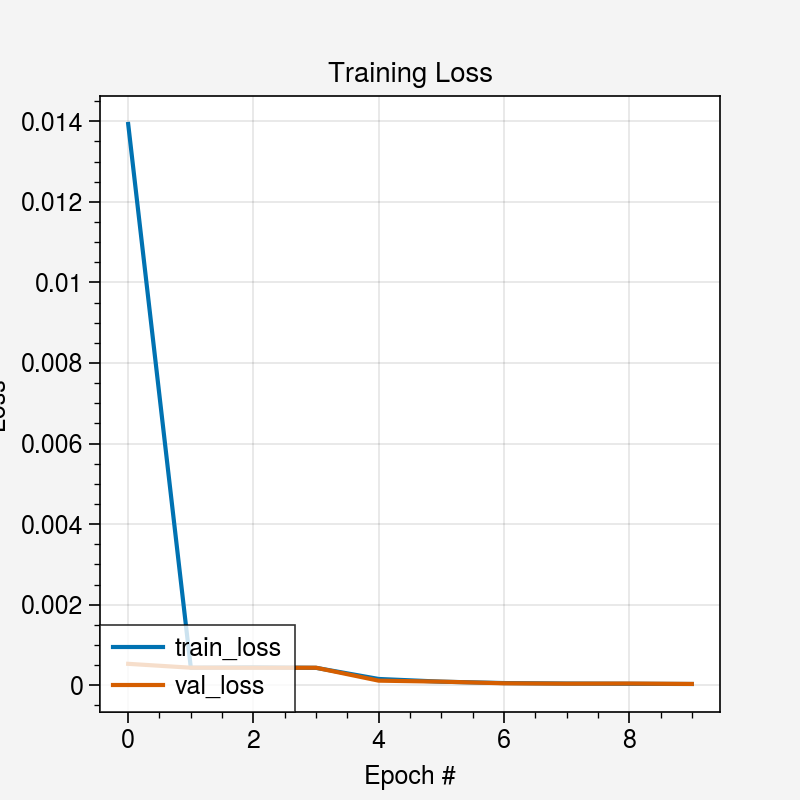

In [10]:
# Loss function plot
N = np.arange(0,10)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

# Save trained autoencoder model

In [11]:
autoencoder.save('autoencoder/processed_data/autoencoder_trained_CN05_1981_2015_running.model',save_format='h5')

# Load trained autoencoder model

In [12]:
autoencoder = load_model('autoencoder/processed_data/autoencoder_trained_CN05_1981_2015_running.model')

# Compute error

In [13]:
def comp_error(images, autoencoder):
    time_max,_,_,_ = np.shape(images)
    errors_ = np.zeros(time_max)
    recons_ = autoencoder.predict_on_batch(images)
    for tt in range(time_max):
        errors_[tt] = np.mean((images[tt] - recons_[tt])**2)
    del(recons_)
    return errors_

In [14]:
errors_all = []
for i in range(len(prec_norm_img_list)//100+1):
    if i != len(prec_norm_img_list)//100:
        errors = comp_error(prec_norm_img_list[i*100:i*100+100], autoencoder)
    else:
        errors = comp_error(prec_norm_img_list[i*100:], autoencoder)
    errors_all = errors_all + errors.tolist()

### save error
with open("autoencoder/processed_data/error_CN05_1981_2015_running.pickle", mode="wb") as f:
    pickle.dump(errors_all, f)

In [15]:
## load error
f = open('autoencoder/processed_data/error_CN05_1981_2015_running.pickle', mode="rb")
errors = pickle.load(f)
errors = np.array(errors)

In [16]:
### compute the 95th percentile of the errors as the threshold to identify anomalies
thresh = np.quantile(errors, 0.95)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 5.879323248518658e-05
[INFO] 322 outliers found


# Ploting anomalous precipitation day

In [17]:
def pad_remover(rdata,multidata=False):
    ndim = rdata.ndim
    if ndim==4:
        if multidata:
            recon = rdata[:,1:-1,2:-3,0] # padwidth1 = ((0,0),(1,1),(2,3))
        else:
            recon = rdata[0,1:-1,2:-3,0]
    elif ndim==3:
        recon = rdata[1:-1,2:-3,0]

    return recon

In [18]:
dates_summer = dates[((dates.month > 4) & (dates.month < 11))]

# Determine winner

In [4]:
from minisom import MiniSom
from scipy.spatial import distance

som_weight_patterns = pd.read_csv('output/som_weight_patterns_obs.csv',index_col=0)

som_weight_pattern1 = som_weight_patterns['pattern1']
som_weight_pattern2 = som_weight_patterns['pattern2']
som_weight_pattern3 = som_weight_patterns['pattern3']
som_weight_pattern4 = som_weight_patterns['pattern4']
som_weight_pattern5 = som_weight_patterns['pattern5']
som_weight_pattern6 = som_weight_patterns['pattern6']

def determine_winner(prec_ano_data):

    data_stack = prec_ano_data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
    data_stack = pd.DataFrame(data_stack)
    data_stack = data_stack.to_numpy()
 
    winners = []
   
    for i in range(len(data_stack)):
        dist1 = distance.euclidean(data_stack[i],som_weight_pattern1)
        dist2 = distance.euclidean(data_stack[i],som_weight_pattern2)
        dist3 = distance.euclidean(data_stack[i],som_weight_pattern3)
        dist4 = distance.euclidean(data_stack[i],som_weight_pattern4)
        dist5 = distance.euclidean(data_stack[i],som_weight_pattern5)
        dist6 = distance.euclidean(data_stack[i],som_weight_pattern6)
        dists = np.array([dist1,dist2,dist3,dist4,dist5,dist6])
        winner = dists.argmin()
        winners.append(winner)

    return winners

In [5]:
prec_ano = xr.open_dataarray('dataset/china_daily_precipitation_summer_anomalies_1981_2015_running.nc')
ano_date = pd.read_csv('output/ano_dates_95th_CN05_1981_2015_running.csv',index_col=0,header=0)
ano_date = pd.to_datetime(ano_date.index,format='%Y-%m-%d')
prec_ano_95th = prec_ano.sel(time = ano_date)

winner = determine_winner(prec_ano_95th)
winner_obs = pd.Series(winner,index=ano_date)
winner_obs.to_csv('output/winner_CN05_1981_2015_running.csv')

# Time series of observed anomalous days

0.08179271708683472 0.4873836109356866


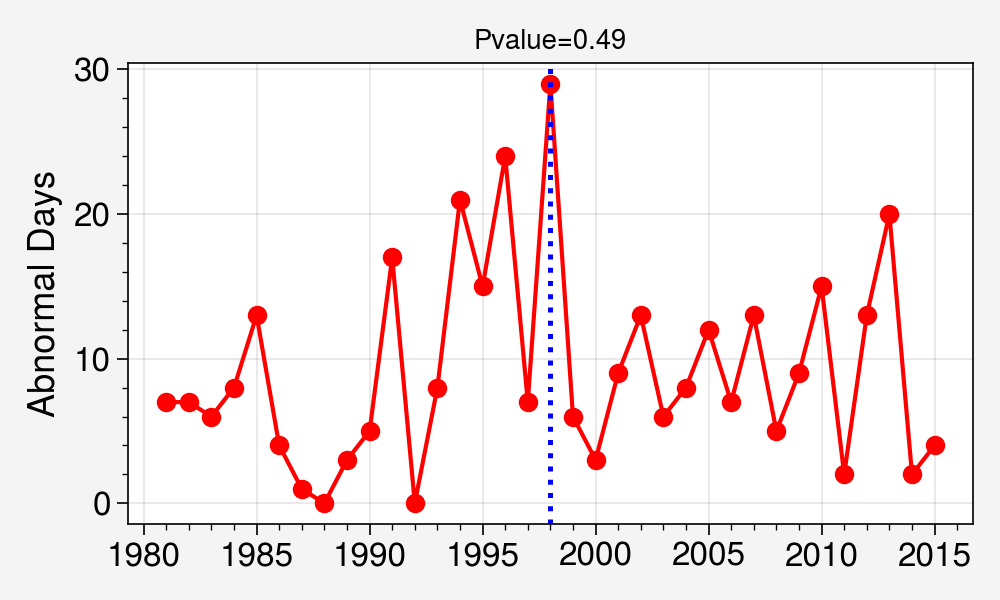

In [22]:
# Time series for anomalous days (using 95th)
ano_dates = dates_summer[idxs]
idxs_pd = pd.Series(idxs)
idxs_pd.index = ano_dates
idxs_pd.to_csv('output/ano_dates_95th_CN05_1981_2015_running.csv')

fig, ax = plt.subplots(figsize=(5,3))

ano_freq = ano_dates.year.value_counts().reindex(dates.year.unique(),fill_value=0).sort_index()
ano_freq.to_csv('output/ano_freq_95th_CN05_1981_2015_running.csv')

# Plot
years = ano_freq.index
# ano_freq = ano_freq['0']
plt.plot(years, ano_freq, "o-", color="r")
plt.axvline(x=1998,color='blue',linewidth=1.8,ls=':')
plt.tick_params(axis='y',colors='black',labelsize = 12)
plt.tick_params(axis='x',colors='black',labelsize = 12)

trend = linregress(years,ano_freq).slope
pval = linregress(years,ano_freq).pvalue
intercept = linregress(years,ano_freq).intercept
print (trend,pval)

if pval <=0.05:
    yy = years * trend + intercept
    plt.plot(years, yy, "--", color="black")
    plt.title("Trend=%.3f day yr$^{-1}$, Pval=%.2f" % (trend,pval),fontdict={'fontsize':13})
else:
    plt.title("Pvalue=%.2f" % (pval))
ax.set_ylabel('Abnormal Days',fontdict={'fontsize':13})

plt.tight_layout()
plt.savefig("figure/abnormal_frequency_time_series_CN05_1981_2015_running.pdf")

In [69]:
ano_freq_fixed_CN05 = pd.read_csv('output/ano_freq_95th_CN05_1981_2015_fixed.csv',index_col=0)
ano_freq_fixed_APHRO = pd.read_csv('output/ano_freq_95th_APHRO_1981_2015_fixed.csv',index_col=0)
ano_freq_running_APHRO = pd.read_csv('output/ano_freq_95th_APHRO_1981_2015_running.csv',index_col=0)
ano_freq_all = pd.concat([ano_freq_fixed_CN05,ano_freq,ano_freq_fixed_APHRO,ano_freq_running_APHRO],axis=1)
ano_freq_all.columns = ['CN05_Fixed','CN05_Running','APHRO_Fixed','APHRO_Running']
# ano_freq_all.plot(figsize=(12,6))

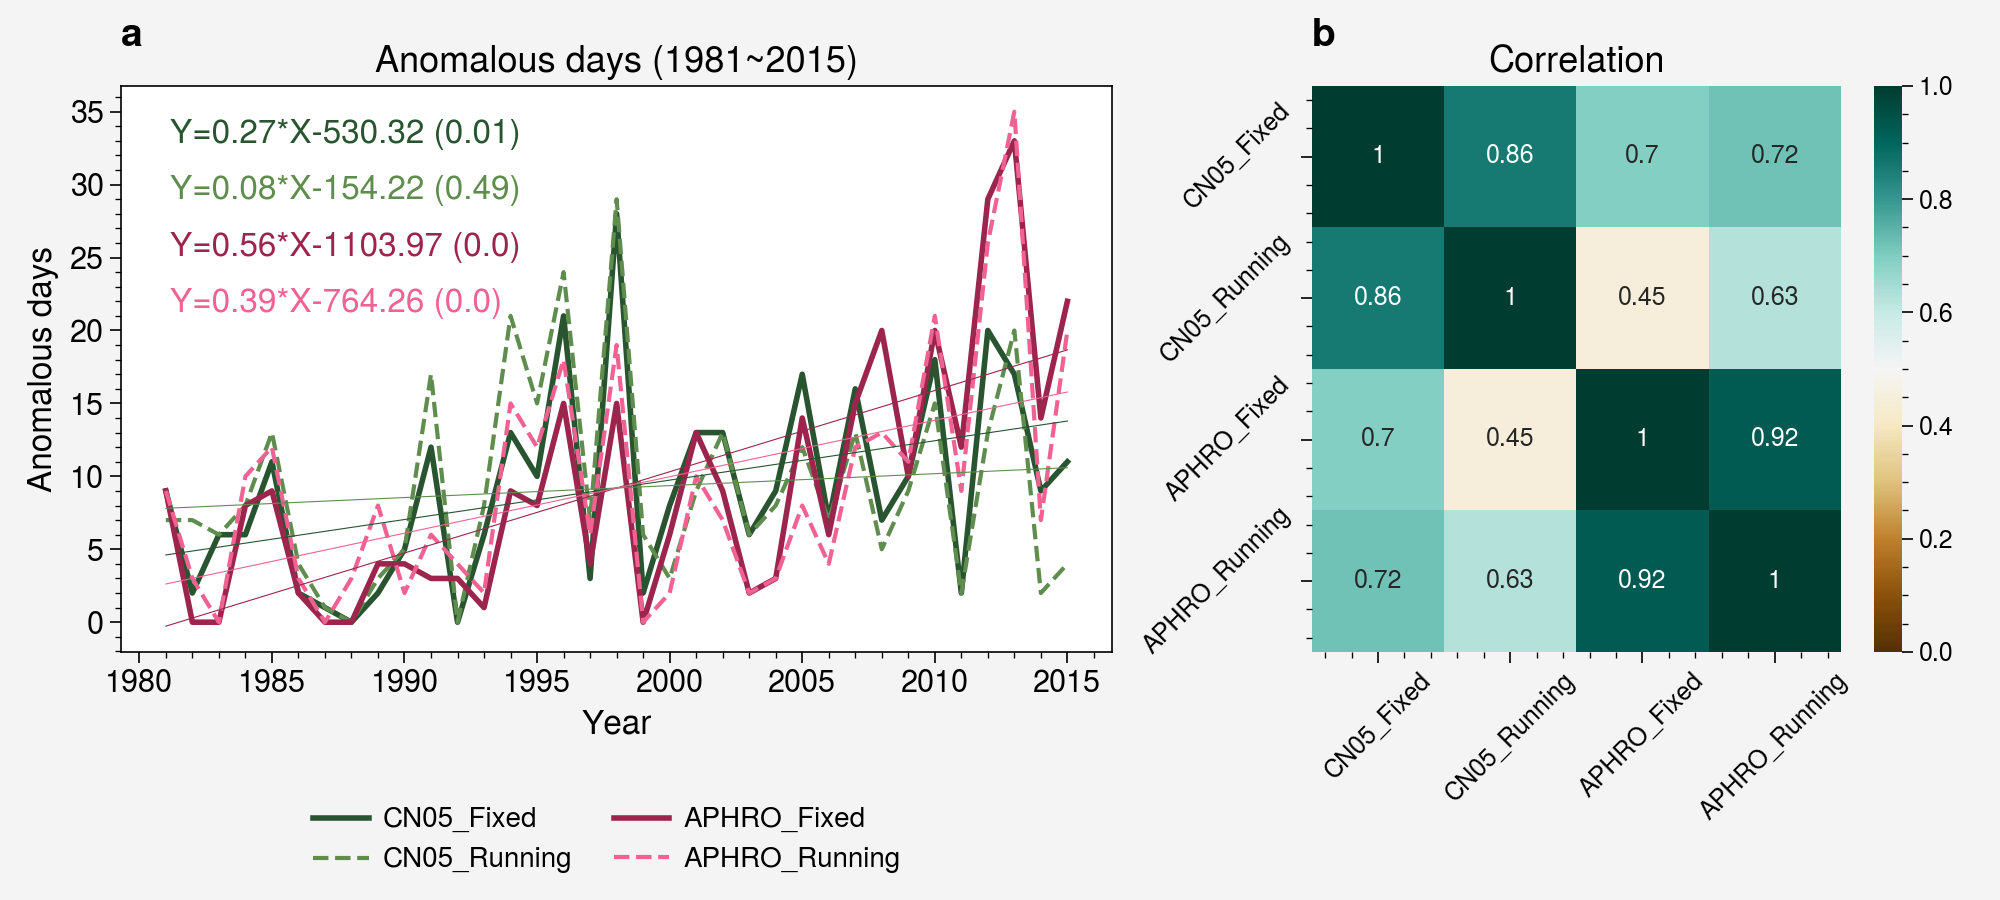

In [74]:
import seaborn as sb

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5), gridspec_kw={'width_ratios': [.6, .4]})
cmap = ['#285430','#5F8D4E','#9C254D','#F06292']
a2 = ax[0].plot(ano_freq_all.index, ano_freq_all['CN05_Fixed'], color='#285430',linewidth=2)
b2 = ax[0].plot(ano_freq_all.index, ano_freq_all['CN05_Running'], color='#5F8D4E',linewidth=1.5,linestyle='dashed')
d  = ax[0].plot(ano_freq_all.index, ano_freq_all['APHRO_Fixed'], color='#9C254D',linewidth=2,alpha=1)
e  = ax[0].plot(ano_freq_all.index, ano_freq_all['APHRO_Running'], color='#F06292',linewidth=1.5,linestyle='dashed')

for i in range(4):
    reg_func = np.poly1d(np.polyfit(ano_freq_all.index, ano_freq_all.iloc[:,i], 1))
    ax[0].plot(ano_freq_all.index,reg_func(ano_freq_all.index),linewidth=0.4,color=cmap[i])
    slope, intercept, _, p, _ = linregress(ano_freq_all.index, ano_freq_all.iloc[:,i])
    if intercept > 0:
        s = 'Y=' + str(round(slope,2)) + '*X+' + str(round(intercept,2)) + ' (' + str(round(p,2)) + ')'
    else:
        s = 'Y=' + str(round(slope,2)) + '*X' + str(round(intercept,2)) + ' (' + str(round(p,2)) + ')'
    ax[0].text(x = 0.05, y = 0.9-0.1*i, s = s, fontsize=12, color = cmap[i],transform=ax[0].transAxes)

ax[0].set_ylabel('Anomalous days',fontsize=12)
ax[0].tick_params(axis='both', which='major', labelsize=11)
ax[0].set_xlabel('Year',fontsize=12)
ax[0].set_title('Anomalous days (1981~2015)',fontsize = 13)
ax[0].legend(
    [a2[0],b2[0],d[0],e[0]], 
    ['CN05_Fixed','CN05_Running','APHRO_Fixed','APHRO_Running'],fancybox = False,frameon=False, bbox_to_anchor=[0.8,-0.25],
    ncol=2,fontsize=10)
ax[0].grid(False)
add_panel_label(ax[0], 'a', x=0, y = 1.12)
heatmap = sb.heatmap(ano_freq_all.corr(),vmin=0,vmax=1,annot=True,cmap='BrBG',ax=ax[1])
add_panel_label(ax[1], 'b', x=0, y = 1.12)
ax[1].grid(False)
ax[1].set_title('Correlation',fontsize = 13)
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.tight_layout()

plt.tight_layout()
plt.savefig("figure/abnormal_frequency_time_series_CN05_vs_APHRO.pdf")